<a href="https://colab.research.google.com/github/TheSpiralArchitect/Phase-1-/blob/main/Phase2_PlanitaryOrbits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries for exoplanet orbital SRL analysis
!pip install --quiet pandas numpy matplotlib seaborn astroquery scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 29.1 MB/s eta 0:00:00


In [2]:
!pip install --upgrade --quiet astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 55.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive

# Step 1: Download exoplanet data
print("Fetching data from NASA Exoplanet Archive...")
planets = NasaExoplanetArchive.query_criteria(
    table="pscomppars",
    select="pl_name,hostname,pl_orbper,pl_orbsmax",
    where="pl_orbper IS NOT NULL and pl_orbsmax IS NOT NULL"
).to_pandas()

print(f"Downloaded {len(planets)} rows.")

# Step 2: Group by system and filter multi-planet systems
multi_systems = planets.groupby("hostname").filter(lambda x: len(x) >= 2)
print(f"Filtered to {multi_systems['hostname'].nunique()} multi-planet systems.")

# Step 3: Normalize periods per system (sorted by distance)
symbol_stream = []
for name, group in multi_systems.groupby("hostname"):
    group_sorted = group.sort_values("pl_orbsmax")
    periods = group_sorted["pl_orbper"].values
    if len(periods) < 2:
        continue
    ratios = periods[1:] / periods[:-1]
    for r in ratios:
        if r < 1.2:
            symbol_stream.append("A")
        elif r < 1.8:
            symbol_stream.append("B")
        else:
            symbol_stream.append("H")

# Save symbolic stream
symbol_array = np.array(symbol_stream)
print(f"Generated symbolic stream of length {len(symbol_array)}")

# Optional preview
from collections import Counter
print("Symbol counts:", Counter(symbol_array))

<ipython-input-3-550548e2b88b>:4: DeprecationWarning: the ``nasa_exoplanet_archive`` module has been moved to astroquery.ipac.nexsci.nasa_exoplanet_archive, please update your imports.
  from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive


Fetching data from NASA Exoplanet Archive...
Downloaded 5324 rows.
Filtered to 914 multi-planet systems.
Generated symbolic stream of length 1384
Symbol counts: Counter({np.str_('H'): 1025, np.str_('B'): 353, np.str_('A'): 6})


Saved symbolic stream to /content/drive/MyDrive/SRL_Phase2_Planetary/symbols/planetary_symbolic_stream.npy


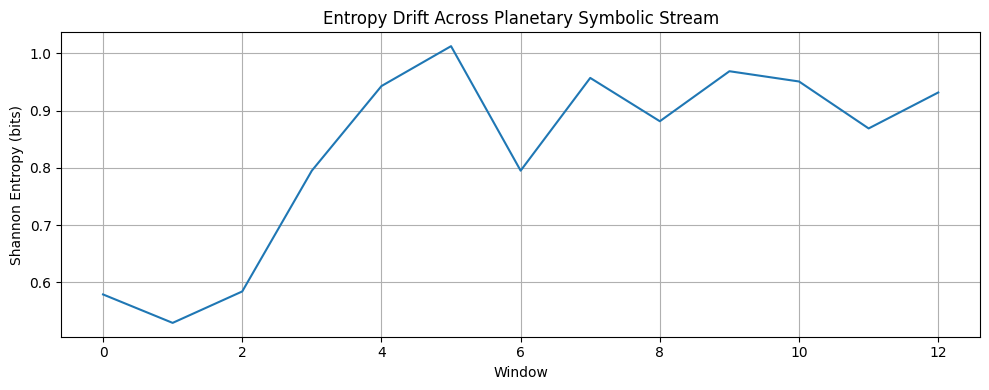

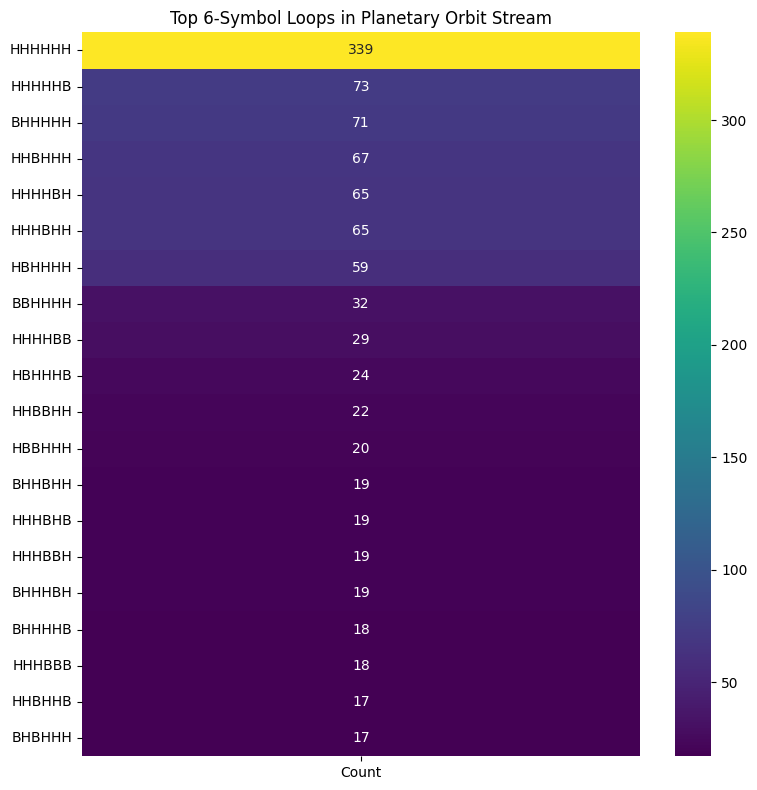

Entropy plot saved to: /content/drive/MyDrive/SRL_Phase2_Planetary/results/planet_entropy_drift.png
Loop heatmap saved to: /content/drive/MyDrive/SRL_Phase2_Planetary/results/planet_loop_heatmap.png


In [4]:
from scipy.stats import entropy
from collections import Counter
import seaborn as sns
import os

# Save paths
base_path = "/content/drive/MyDrive/SRL_Phase2_Planetary"
symbol_output = f"{base_path}/symbols/planetary_symbolic_stream.npy"
entropy_plot_path = f"{base_path}/results/planet_entropy_drift.png"
heatmap_path = f"{base_path}/results/planet_loop_heatmap.png"
os.makedirs(f"{base_path}/symbols", exist_ok=True)
os.makedirs(f"{base_path}/results", exist_ok=True)

# Save symbolic stream
np.save(symbol_output, symbol_array)
print(f"Saved symbolic stream to {symbol_output}")

# Entropy drift
window_size = 100
entropies = []
for i in range(0, len(symbol_array) - window_size, window_size):
    window = symbol_array[i:i + window_size]
    counts = Counter(window)
    probs = np.array(list(counts.values())) / sum(counts.values())
    entropies.append(entropy(probs, base=2))

plt.figure(figsize=(10, 4))
plt.plot(entropies)
plt.title("Entropy Drift Across Planetary Symbolic Stream")
plt.xlabel("Window")
plt.ylabel("Shannon Entropy (bits)")
plt.grid(True)
plt.tight_layout()
plt.savefig(entropy_plot_path)
plt.show()

# Loop detection (6-grams)
symbol_str = ''.join(symbol_array)
loops = [symbol_str[i:i+6] for i in range(len(symbol_str) - 6)]
loop_counts = Counter(loops)
top_loops = loop_counts.most_common(20)

# Heatmap of top 6-gram loops
motifs = [loop for loop, _ in top_loops]
counts = [count for _, count in top_loops]
heat_data = np.array(counts).reshape(-1, 1)

plt.figure(figsize=(8, 8))
sns.heatmap(heat_data, annot=True, fmt="d", cmap="viridis",
            yticklabels=motifs, xticklabels=["Count"])
plt.title("Top 6-Symbol Loops in Planetary Orbit Stream")
plt.tight_layout()
plt.savefig(heatmap_path)
plt.show()

print(f"Entropy plot saved to: {entropy_plot_path}")
print(f"Loop heatmap saved to: {heatmap_path}")